In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.layers import LSTM, Dense

In [3]:
main_labels = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
labels_list = []

for class_dir in os.listdir("data/train"):
    labels_list += [class_dir if class_dir in main_labels else "unknown" for label in os.listdir(os.path.join("data/train", class_dir))]


train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory="data/train",
    labels=labels_list,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')


Found 64727 files belonging to 11 classes.
Using 51782 files for training.
Using 12945 files for validation.


In [4]:
label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)



label names: ['down' 'go' 'left' 'no' 'off' 'on' 'right' 'stop' 'unknown' 'up' 'yes']


In [5]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)


(64, 16000)


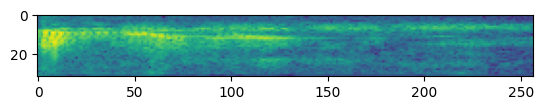

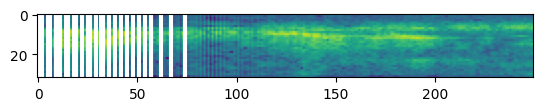

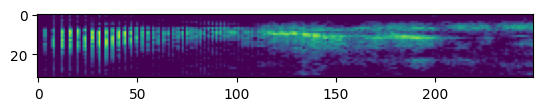

In [6]:
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)


spectrogram = tfio.audio.spectrogram(example_audio[0], 
nfft=512, # modifies x axis in spectrogram
window=512, 
stride=512 # modifies y axis in spectrogram
)
 
plt.figure()
#plotting spectrogram
plt.imshow(tf.math.log(spectrogram).numpy()) 
plt.show()


# Convert spectrogram to mel spectrogram with 250 mel bands
spectrogram_mel = tfio.audio.melscale(spectrogram, rate=16000, mels=250, fmin=0, fmax=7000)
plt.figure()
plt.imshow(tf.math.log(spectrogram_mel).numpy())
 
#Convert spectrogram to decibel scale with top_db=70
spectrogram_dbscale = tfio.audio.dbscale(spectrogram_mel, top_db=70)
plt.figure()
 
plt.imshow(spectrogram_dbscale.numpy()) 
plt.show()


In [7]:
def preprocess_data_into_specs(ds, **kwargs):
  ds = ds.map(
      map_func=lambda audio,label: (tfio.audio.spectrogram(audio, **kwargs), label),
      num_parallel_calls=tf.data.AUTOTUNE)
  return ds.map(
      map_func=lambda audio,label: (tf.math.log(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)


In [8]:
spec_train_ds = preprocess_data_into_specs(train_ds, nfft=512, window=512, stride=512)

In [9]:
for example_spec_audio, example_spec_labels in spec_train_ds.take(1):
    print(example_spec_audio.shape)

(64, 32, 257)


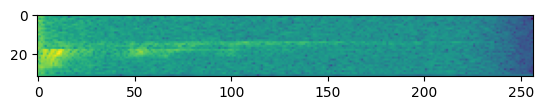

In [10]:
plt.imshow(example_spec_audio[7].numpy())
plt.show() 

In [ ]:
input_shape=(128,1000)
model = keras.Sequential()
model.add(LSTM(128,input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(24, activation='softmax'))
model.summary()